## Introduction

It is no secret that our elected officials in this country oftentimes live substantially better than the people they are elected to represent. The fact that a majority of the members of the 116th congress as millionaires (https://www.opensecrets.org/news/2020/04/majority-of-lawmakers-millionaires/) tells you that they are richer than most Americans. 

After several members of congress were in hot water for selling stocks right before the pandemic began (https://www.cnbc.com/2020/03/23/coronavirus-sec-warns-on-insider-trading-after-loeffler-sales.html) and were then investigated for insider trading, we thought that this is probably a very common occurrence for them. After a little bit of research, we found some articles that supported the notion (https://www.cnbc.com/2020/03/23/coronavirus-sec-warns-on-insider-trading-after-loeffler-sales.html). Fortunately for us, every stock trade made by a member of congress is published publicly. 

Though we don't have the access to the information needed to make an accusations, we still think there is valuable knowledge in these trades. The plan is to investigate the trades made by member of congress, and see just how well they're doing in terms of numbers. We can see exactly when a stock is bought and sold, and through webscraping we were able to calculate the value increase on purchases. This led us to an idea - does simply copying the trades made by congresspeople yield higher returns than trying to invest on your own? We can investigate.

It's likely that we cannot stop insider trading in congress, or even prove it. But with the information we're given we can imitate them even if we don't know why they're trading in a certain way. 

We will use this data to investigate the average rate of return on the stock portfolios of congresspeople, and if it is worth copying them. There is a delay in the reporting of this data, so we also aim to determine if this delay in the reporting has a substantial impact on your potential returns should you copy the stock purchases as soon as the information is made available to you. 

## Data Description

For our data we started by pulled two large csvs, one of senate stock transactions and one of house of representative stock transactions. These both contain several years worth of stock transactions and include info such as ticker, company name, transaction date, purchaser name, and dollar amount range. We are also going to be using live stock price data, scraped from yahoo finance for all stocks purchased by congressmen. 
[csvs](#csvs)
[live_price](#live_price)
[past_price](#past_price)

We clean the data [below](#below) and then replace the dollar value ranges given with a min mid and max of each range to be used later. We filter our dataframes to have purchases only as we were more interested in them. Next we add live price data and then past price data for every transaction [here](#here) and [also_here](#also_here).

We often have to export intermediate dataframes to csvs and read them back in as our functions for adding live and past prices take an extremely long time to run. As this is done there is more dataframe manipulation and cleaning. [start](#start) [end](#end)

Please find our graphs at the [bottom](#bottom) with descriptions.

## Method
Our goal for the machine learning was to determine if they 6-week delay in reporting times has a significant impact on the long-term returns. Basically, did the congressperson purchase stock at the absolute perfect time, and is the purchase worth imitating weeks down the line. 

We opted to use a linear regression for our machine learning analysis. A linear regression is used to predict the relationship between two values, and seeing as our goal is to investigate the impact of the purchase date on the total returns, that made a lot of sense. We could have opted for a random forest regression because this is used for feature importance, but decided not to because we are only investigating the date impact. 

This is an important investigation to make because if we were to begin imitating these trades, we would have no control of this delay in reporting time. Therefore, it's beneficial to know the impact of it. 

In [1]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.linear_model import LinearRegression

Initial data csvs
<a id='csvs'></a>

In [2]:
# Read in the csv data, sets the index as the transaction date column
senate = pd.read_csv("all_transactions_senate.csv", index_col="transaction_date", parse_dates=True)
house = pd.read_csv("all_transactions_house.csv", index_col="transaction_date", parse_dates=True)

In [3]:
senate.head(3)

,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link
transaction_date,,,,,,,,,
2021-03-03,Spouse,UBSI,"United Bankshares, Inc.",Stock,Purchase,"$100,001 - $250,000",--,Shelley M Capito,https://efdsearch.senate.gov/search/view/ptr/a...
2021-03-09,Spouse,USB,U.S. Bancorp,Stock,Purchase,"$1,001 - $15,000",--,Shelley M Capito,https://efdsearch.senate.gov/search/view/ptr/a...
2021-03-09,Spouse,JPM,JPMorgan Chase &amp; Co.,Stock,Purchase,"$1,001 - $15,000",--,Shelley M Capito,https://efdsearch.senate.gov/search/view/ptr/a...


In [4]:
house.head(3)

,disclosure_year,disclosure_date,owner,ticker,asset_description,type,amount,representative,district,ptr_link,cap_gains_over_200_usd
transaction_date,,,,,,,,,,,
2020-02-24,2020,04/28/2020,join,BHC,Bausch Health Companies Inc.,purchase,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False
2020-03-06,2020,04/28/2020,join,BAH,Booz Allen Hamilton Holding Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,True
2020-03-23,2020,04/28/2020,join,BYD,Boyd Gaming Corporation,sale_full,"$1,001 - $15,000",Hon. Susie Lee,NV03,https://disclosures-clerk.house.gov/public_dis...,False


Cleaning data
<a id='below'></a>

In [5]:
# All Senator and house of representatives data cleaned

# Read in the csv data, sets the index as the transaction date column
senate = pd.read_csv("all_transactions_senate.csv", index_col="transaction_date", parse_dates=True)
house = pd.read_csv("all_transactions_house.csv", index_col="transaction_date", parse_dates=True)

# Remove specified columns
senate = senate.drop(columns=["owner", "ptr_link", "asset_type", "comment"])
house = house.drop(columns=["owner", "ptr_link", "disclosure_year", "disclosure_date", "district", "cap_gains_over_200_usd"])

# Gets rid of NaN aka the empty values
senate = senate.dropna(axis=0)
senate = senate[~senate["ticker"].str.contains("--")]
house = house.dropna(axis=0)
house = house[~house["ticker"].str.contains("--")]

# Clarify a column name
senate.rename(columns={"amount": "midpoint amount ($)"}, inplace=True)
house.rename(columns={"amount": "midpoint amount ($)"}, inplace=True)

# Replace all the string categories with midpoint ints
midpoints_list = [7500, 32500, 75000, 175000, 375000, 750000, 3000000, 15000000, 37500000, 7500]
ranges_list = ["$1,001 - $15,000", "$15,001 - $50,000", "$50,001 - $100,000", "$100,001 - $250,000", 
               "$250,001 - $500,000", "$500,001 - $1,000,000", "$1,000,001 - $5,000,000",
               "$5,000,001 - $25,000,000", "$25,000,001 - $50,000,000", "$1,001 -"]

senate.replace(ranges_list, midpoints_list, inplace=True)
house.replace(ranges_list, midpoints_list, inplace=True)


In [6]:
# Set up new data frame for min max median of each range
senate_temp = senate.reset_index()
senate_mmm = senate_temp
senate_mmm.columns = senate_temp.columns
senate_mmm.set_index("transaction_date", inplace=True)

house_temp = house.reset_index()
house_mmm = house_temp
house_mmm.columns = house_temp.columns
house_mmm.set_index("transaction_date", inplace=True)

In [7]:
# find the minimum and maximum values of the purchase for the senate
min_list = []
max_list = []
values = senate_mmm['midpoint amount ($)'].to_list()

for row in range(len(values)):
    if values[row] in range(1000, 15000):
        min_list.append(1000)
        max_list.append(15000)
    if values[row] in range(15001, 50000):
        min_list.append(15001)
        max_list.append(50000)
    if values[row] in range(50001, 100000):
        min_list.append(50001)
        max_list.append(100000)
    if values[row] in range(100001, 250000):
        min_list.append(100001)
        max_list.append(250000)
    if values[row] in range(250001, 500000):
        min_list.append(250001)
        max_list.append(500000)
    if values[row] in range(500001, 1000000):
        min_list.append(500001)
        max_list.append(1000000)
    if values[row] in range(1000001, 5000000):
        min_list.append(1000001)
        max_list.append(5000000)
    if values[row] in range(5000001, 250000000):
        min_list.append(5000001)
        max_list.append(250000000)

#find the minimum and maximum values of the purchase for the house
min_list_house = []
max_list_house = []
values_house = house_mmm['midpoint amount ($)'].to_list()

for row in range(len(values_house)):
    if values_house[row] in range(1000, 15000):
        min_list_house.append(1000)
        max_list_house.append(15000)
    if values_house[row] in range(15001, 50000):
        min_list_house.append(15001)
        max_list_house.append(50000)
    if values_house[row] in range(50001, 100000):
        min_list_house.append(50001)
        max_list_house.append(100000)
    if values_house[row] in range(100001, 250000):
        min_list_house.append(100001)
        max_list_house.append(250000)
    if values_house[row] in range(250001, 500000):
        min_list_house.append(250001)
        max_list_house.append(500000)
    if values_house[row] in range(500001, 1000000):
        min_list_house.append(500001)
        max_list_house.append(1000000)
    if values_house[row] in range(1000001, 5000000):
        min_list_house.append(1000001)
        max_list_house.append(5000000)
    if values_house[row] in range(5000001, 250000000):
        min_list_house.append(5000001)
        max_list_house.append(250000000)

In [8]:
#add the minimum and maximum to the dataframe
senate_mmm['min'] = min_list
senate_mmm['max'] = max_list
house_mmm['min'] = min_list_house
house_mmm['max'] = max_list_house

In [9]:
senate_purchase = senate_mmm[senate_mmm['type'] == "Purchase"]
senate_purchase.reset_index(inplace=True)
house_purchase = house_mmm[house_mmm['type'] == "purchase"]
house_purchase.reset_index(inplace=True)

In [10]:
house_purchase

,transaction_date,ticker,asset_description,type,midpoint amount ($),representative,min,max
0,2020-02-24,BHC,Bausch Health Companies Inc.,purchase,7500,Hon. Susie Lee,1000,15000
1,2020-02-04,CTLT,"Catalent, Inc.",purchase,7500,Hon. Susie Lee,1000,15000
2,2020-03-24,CNC,Centene Corporation,purchase,7500,Hon. Susie Lee,1000,15000
3,2020-03-31,DG,Dollar General Corporation,purchase,7500,Hon. Susie Lee,1000,15000
4,2020-03-06,AQUA,Evoqua Water Technologies Corp.,purchase,7500,Hon. Susie Lee,1000,15000
...,...,...,...,...,...,...,...,...
4015,2020-05-05,VIAV,Viavi Solutions Inc.,purchase,7500,Hon. Josh Gottheimer,1000,15000
4016,2020-05-07,VIAV,Viavi Solutions Inc.,purchase,7500,Hon. Josh Gottheimer,1000,15000
4017,2020-05-04,USFD,US Foods Holding Corp.,purchase,7500,Hon. Adam Kinzinger,1000,15000
4018,2020-05-26,AAL,"American Airlines Group, Inc.",purchase,7500,Hon. Adam Kinzinger,1000,15000


Live price scraper
<a id='live_price'></a>

In [11]:
def live_price(ticker):
    '''Gets the current stock price for a given ticker

    https://finance.yahoo.com/quote/%7Bticker%7D?p=%7Bticker%7D&.tsrc=fin-srch

    Args:
        ticker (str): the ticker for the stock we want to pull the price for

    Returns:
        price (float): the live price of the ticker that we gave the function

    '''
    # create the url for yahoo 
    url = f"https://finance.yahoo.com/quote/{ticker}?p={ticker}&.tsrc=fin-srch"
    # convert to html string
    html_str = requests.get(url).text

    # open soup object
    soup = BeautifulSoup(html_str)

    # grab the current stock price
    try:
        price = soup.find('span', class_= "Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)").text
        try:
            price = price.replace(',', '')
        except Exception as e:
            pass
        price = float(price)
    except Exception as e:
        price = 0


    return price

In [12]:
import time
import datetime

def past_price(ticker, date):
    '''Gets the current stock price for a given ticker

    https://finance.yahoo.com/quote/%7Bticker%7D?p=%7Bticker%7D&.tsrc=fin-srch

    Args:
        ticker (str): the ticker for the stock we want to pull the price for

    Returns:
        price (float): the live price of the ticker that we gave the function

    '''
    unixtime = time.mktime(date.timetuple())
    unixtime = int(unixtime + 50000)

    # create the url for yahoo 
    url = f"https://finance.yahoo.com/quote/{ticker}/history?period1=1436659200&period2={unixtime}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
    # convert to html string
    html_str = requests.get(url).text

    # open soup object
    soup = BeautifulSoup(html_str)

    # grab the current stock price

    try:
        price = soup.find('td', class_= 'Py(10px) Pstart(10px)').text
        try:
            price = price.replace(',', '')
        except Exception as e:
            pass
        price = float(price)
    except Exception as e:
        price = 0


    return price

In [13]:
import time
import datetime

def past_price_plus_6weeks(ticker, date):
    '''Gets the current stock price for a given ticker

    https://finance.yahoo.com/quote/%7Bticker%7D?p=%7Bticker%7D&.tsrc=fin-srch

    Args:
        ticker (str): the ticker for the stock we want to pull the price for

    Returns:
        price (float): the live price of the ticker that we gave the function

    '''
    unixtime = time.mktime(date.timetuple())
    unixtime = int(unixtime + 50000 + 3628800)

    # create the url for yahoo 
    url = f"https://finance.yahoo.com/quote/{ticker}/history?period1=1436659200&period2={unixtime}&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
    # convert to html string
    html_str = requests.get(url).text

    # open soup object
    soup = BeautifulSoup(html_str)

    # grab the current stock price

    try:
        price = soup.find('td', class_= 'Py(10px) Pstart(10px)').text
        try:
            price = price.replace(',', '')
        except Exception as e:
            pass
        price = float(price)
    except Exception as e:
        price = 0


    return price

### Pulling live price data for all stocks purchased

<a id='here'></a>
<a id='start'></a>

In [14]:
# We did not run this because it takes a super long time so we ran it once and joined the data we created
# into our dataframe and exported it to csv and then read the csv back in

#pricer_list = []
#unique_senate = senate_purchase['ticker'].unique().tolist()

#for item in unique_senate:
#    pricer_list.append(live_price(item))
    
    
#df_sentick = pd.DataFrame(columns = None)
#df_sentick['ticker'] = unique_senate
#df_sentick['price'] = pricer_list
#df_sentick

#senate_data = pd.merge(senate_purchase, df_sentick, how="left")

#senate_data.to_csv("senate_data.csv", index=False)

In [15]:
senate_data = pd.read_csv("senate_data_final.csv", index_col="transaction_date")

In [16]:
# Commenting out this code because it takes so long to run and we saved it as a csv

#unique_house = house_purchase['ticker'].unique().tolist()
#house_pricer_list = []

#for item in unique_house:
#    house_pricer_list.append(live_price(item))
    
    
#df_housetick = pd.DataFrame(columns = None)
#df_housetick['ticker'] = unique_house
#df_housetick['price'] = house_pricer_list
#df_housetick

#house_data = pd.merge(house_purchase, df_housetick, how="left")

#house_data.to_csv("house_data.csv", index=False)

In [17]:
house_data = pd.read_csv("house_data_final.csv", index_col="transaction_date")

# Dropping weird data point
#house_data.drop(["0019-08-02"], inplace=True)

Scraping past (transaction date) price data
<a id='past_price'></a>

### Pull past price data of each stock purchased
<a id='also_here'></a>

In [18]:
# Split into smaller dataframes so we can loop through each of them faster
sp1 = senate_purchase[:500]
sp2 = senate_purchase[500:1000]
sp3 = senate_purchase[1000:1500]
sp4 = senate_purchase[1500:2000]
sp5 = senate_purchase[2000:2500]
sp6 = senate_purchase[2500:]

In [19]:
past_price_list = []

In [20]:
# Tried to create a for loop to run through all the split dfs instead of running each individually
# but it slowed it down imensly and my computer wouldnt complete it so we had to do them individually

# counter = 0

# for item in range(len(sp1)):
#     past_price_list.append(past_price(sp1["ticker"][counter], 
#                                       sp1["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [21]:
# counter = 500

# for item in range(len(sp2)):
#     past_price_list.append(past_price(sp2["ticker"][counter], 
#                                       sp2["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [22]:
# counter = 1000

# for item in range(len(sp3)):
#     past_price_list.append(past_price(sp3["ticker"][counter], 
#                                       sp3["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [23]:
# counter = 1500

# for item in range(len(sp4)):
#     past_price_list.append(past_price(sp4["ticker"][counter], 
#                                       sp4["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [24]:
# counter = 2000

# for item in range(len(sp5)):
#     past_price_list.append(past_price(sp5["ticker"][counter], 
#                                       sp5["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [25]:
# counter = 2500

# for item in range(len(sp6)):
#     past_price_list.append(past_price(sp6["ticker"][counter], 
#                                       sp6["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [26]:
six_week_past_price_list = []

In [27]:
# Same as above part, I had to do them individually here

# counter = 0

# for item in range(len(sp1)):
#     six_week_past_price_list.append(past_price_plus_6weeks(sp1["ticker"][counter], 
#                                                            sp1["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [28]:
# counter = 500

# for item in range(len(sp2)):
#     six_week_past_price_list.append(past_price_plus_6weeks(sp2["ticker"][counter], 
#                                                            sp2["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [29]:
# counter = 1000

# for item in range(len(sp3)):
#     six_week_past_price_list.append(past_price_plus_6weeks(sp3["ticker"][counter], 
#                                                            sp3["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [30]:
# counter = 1500

# for item in range(len(sp4)):
#     six_week_past_price_list.append(past_price_plus_6weeks(sp4["ticker"][counter], 
#                                                            sp4["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [31]:
# counter = 2000

# for item in range(len(sp5)):
#    six_week_past_price_list.append(past_price_plus_6weeks(sp5["ticker"][counter], 
#                                                           sp5["transaction_date"][counter]))
#    counter += 1
#    print(counter)

In [32]:
# counter = 2500

# for item in range(len(sp6)):
#     six_week_past_price_list.append(past_price_plus_6weeks(sp6["ticker"][counter], 
#                                                            sp6["transaction_date"][counter]))
#     counter += 1
#     print(counter)

In [33]:
# This code cannot run because of the above code taking way to long to run and being commented out

### This creates an empty dataframe and adds the price data we scraped to it        
# df_senate = pd.DataFrame(columns = None)
# df_senate['transaction_date'] = senate_purchase["transaction_date"]
# df_senate['ticker'] = senate_purchase["ticker"]
# df_senate['t_date_price'] = past_price_list
# df_senate['t_date_plus6w_price'] = six_week_past_price_list

### This adds the scraped data to our senate dataframe
# senate_data["t_date_price"] = df_senate["t_date_price"].values
# senate_data["t_date_plus6w_price"] = df_senate["t_date_plus6w_price"].values

### Dropping some bad data
# drop_list = list(range(2735, len(df_senate)))
# senate_data = senate_data.drop(senate_data.index[drop_list])

### Exporting to csv so we can quickly and easily read it back in
# senate_data.reset_index(inplace=True)

# senate_data.to_csv("senate_data_final.csv", index=False)

In [34]:
# read in the senate csv created above and fine tune it for final uses
senate_data_final = pd.read_csv("senate_data_final.csv", index_col="transaction_date")

sen_col_list = ["ticker", "asset_description", "senator", "min", "midpoint amount ($)", "max",
            "t_date_price", "t_date_plus6w_price", "price"]

senate_data_final = senate_data_final[sen_col_list]
senate_data_final = senate_data_final.rename({"min": "min ($)", "midpoint amount ($)": "median ($)",
                                            "max": "max ($)","t_date_price": "transac_price",
                                            "t_date_plus6w_price": "transac_plus6wk_price",
                                            "price": "current_price"}, axis="columns")

senate_data_final.replace(0, np.nan, inplace=True)
senate_data_final = senate_data_final.dropna()

In [35]:
# Split into smaller dataframes so we can loop through each of them faster
hp1 = house_purchase[:500]
hp2 = house_purchase[500:1000]
hp3 = house_purchase[1000:1500]
hp4 = house_purchase[1500:2000]
hp5 = house_purchase[2000:2500]
hp6 = house_purchase[2500:3000]
hp7 = house_purchase[3000:3500]
hp8 = house_purchase[3500:]

In [36]:
house_purchase

,transaction_date,ticker,asset_description,type,midpoint amount ($),representative,min,max
0,2020-02-24,BHC,Bausch Health Companies Inc.,purchase,7500,Hon. Susie Lee,1000,15000
1,2020-02-04,CTLT,"Catalent, Inc.",purchase,7500,Hon. Susie Lee,1000,15000
2,2020-03-24,CNC,Centene Corporation,purchase,7500,Hon. Susie Lee,1000,15000
3,2020-03-31,DG,Dollar General Corporation,purchase,7500,Hon. Susie Lee,1000,15000
4,2020-03-06,AQUA,Evoqua Water Technologies Corp.,purchase,7500,Hon. Susie Lee,1000,15000
...,...,...,...,...,...,...,...,...
4015,2020-05-05,VIAV,Viavi Solutions Inc.,purchase,7500,Hon. Josh Gottheimer,1000,15000
4016,2020-05-07,VIAV,Viavi Solutions Inc.,purchase,7500,Hon. Josh Gottheimer,1000,15000
4017,2020-05-04,USFD,US Foods Holding Corp.,purchase,7500,Hon. Adam Kinzinger,1000,15000
4018,2020-05-26,AAL,"American Airlines Group, Inc.",purchase,7500,Hon. Adam Kinzinger,1000,15000


In [37]:
# A different groupmate worked on the house part, his computer was able to handle the loop and since
# the loop is more efficient, we have done it that way here

# house_past_price_list = []
# house_df_list = [hp1, hp2, hp3, hp4, hp5, hp6, hp7, hp8]
# counter = 0

# for df in house_df_list:

#     for item in range(len(df)):
#         try:
#             house_past_price_list.append(past_price(df["ticker"][counter], 
#                                                     df["transaction_date"][counter]))
#         except Exception as e:
#             print('something went wrong, moving on')
            
            
#         print(counter)
#         counter += 1

In [38]:
# Same as above

# 6w_house_past_price_list = []
# house_df_list = [hp1, hp2, hp3, hp4, hp5, hp6, hp7, hp8]
# counter = 0

# for df in house_df_list:

#     for item in range(len(df)):
#         try:
#             6w_house_past_price_list.append(past_price_6weeks(df["ticker"][counter], 
#                                                     df["transaction_date"][counter]))
#         except Exception as e:
#             print('something went wrong, moving on')
            
            
#         print(counter)
#         counter += 1

In [39]:
### This creates an empty dataframe and adds the price data we scraped to it 
# df_house = pd.DataFrame(columns = None)
# df_house['transaction_date'] = house_purchase["transaction_date"]
# df_house['ticker'] = house_purchase["ticker"]
# df_house['t_date_price'] = house_past_price_list
# df_house['t_date_price'] = 6w_house_past_price_list

### This adds the scraped data to our house dataframe
# house_data["t_date_price"] = df_house["t_date_price"].values
# house_data["t_date_plus6w_price"] = df_house["t_date_plus6w_price"].values

### Exporting to csv so we can quickly and easily read it back in
# house_data.reset_index(inplace=True)

# house_data.to_csv("house_data_final.csv", index=False)

In [40]:
# read in the house csv created above and fine tune it for final uses
house_data_final = pd.read_csv("house_data_final.csv", index_col="transaction_date")

col_list = ["ticker", "asset_description", "representative", "min", "midpoint amount ($)", "max",
            "t_date_price", "t_date_plus6w_price", "price"]

house_data_final = house_data_final[col_list]
house_data_final = house_data_final.rename({"min": "min ($)", "midpoint amount ($)": "median ($)",
                                            "max": "max ($)","t_date_price": "transac_price",
                                            "t_date_plus6w_price": "transac_plus6wk_price",
                                            "price": "current_price"}, axis="columns")

house_data_final.replace(0, np.nan, inplace=True)
house_data_final = house_data_final.dropna()

End of data cleaning/combining
<a id='end'></a>

### Functions 

In [41]:
def get_pct_change(past_price, current_price):
    """ Does a simple percent change given two prices
    Args:
        past_price (float): a past price
        current_price (float): the current price

    Returns:
        a percent change between the two given numbers
    
    """
    
    # Runs a basic percent change formula 
    if current_price == past_price:
        return 0
    try:
        return round(((current_price - past_price) / past_price * 100.0), 2)
    except ZeroDivisionError:
        return float('inf')

In [42]:
df_list = [senate_data_final, house_data_final]

# loop through each dataframe
for df in df_list:
    
    # Create lists for adding to df
    six_wk_pct_changes = []
    total_pct_change = []
    
    # loop through the rows 
    for row in range(len(df)):
    
        # calculate pct change for every row and append to a list
        six_wk_pct_changes.append(get_pct_change(df["transac_price"][row], 
                                                 df["transac_plus6wk_price"][row]))
        
        total_pct_change.append(get_pct_change(df["transac_price"][row], df["current_price"][row]))
    
    # Add the pct changes to the dataframe
    df["6w_pct_change"] = six_wk_pct_changes
    df["total_pct_change"] = total_pct_change
    

In [43]:
def get_current_value(value, pct_change):
    """ Calculates a new value of a transaction based on the old value of it and its percent change
    Args:
        value (float): the starting value of a transaction
        pct_change (float): percent change calculated earlier 

    Returns:
        value (float): the updated value of a transaction
    
    """
    
    value = round((value * (pct_change / 100 + 1)), 2)
    
    return value

In [44]:
df_list = [senate_data_final, house_data_final]

# loop through each dataframe
for df in df_list:
    
    # Create lists for adding to df
    min_6w = []
    mid_6w = []
    max_6w = []
    min_current = []
    mid_current = []
    max_current = []
    
    # run through each row in the dataframe
    for row in range(len(df)):
    
        # Get the current value for each row and append to lists
        min_6w.append(get_current_value(df["min ($)"][row], df["6w_pct_change"][row]))
        mid_6w.append(get_current_value(df["median ($)"][row], df["6w_pct_change"][row]))
        max_6w.append(get_current_value(df["max ($)"][row], df["6w_pct_change"][row]))
        
        min_current.append(get_current_value(df["min ($)"][row], df["total_pct_change"][row]))
        mid_current.append(get_current_value(df["median ($)"][row], df["total_pct_change"][row]))
        max_current.append(get_current_value(df["max ($)"][row], df["total_pct_change"][row]))
        
    # Add the lists to the dataframe    
    df["min 6w ($)"] = min_6w
    df["mid 6w ($)"] = mid_6w
    df["max 6w ($)"] = max_6w
    
    df["min current ($)"] = min_current
    df["mid current ($)"] = mid_current
    df["max current ($)"] = max_current
    

In [45]:
# Find the average returns per senator and representative
sixwk = senate_data_final.groupby("senator")["6w_pct_change"].mean().reset_index()
total = senate_data_final.groupby("senator")["total_pct_change"].mean().reset_index()

sixwk_house = house_data_final.groupby("representative")["6w_pct_change"].mean().reset_index()
total_house = house_data_final.groupby("representative")["total_pct_change"].mean().reset_index()

In [46]:
# 6wk average return for all senators and below representatives
senate_average = total["total_pct_change"].mean()

In [47]:
house_average = total_house["total_pct_change"].mean()

In [48]:
# Annualize our average 6 week returns for senate/house to get average annual returns
senate_annual = ((senate_data_final["6w_pct_change"].mean() / 100 + 1)**9 - 1) * 100
house_annual = ((house_data_final["6w_pct_change"].mean() / 100 + 1)**9 - 1) * 100
print(senate_annual)
print(house_annual)

24.586514697904516
45.444308127854384


### Visualizations and explanations
<a id='bottom'></a>

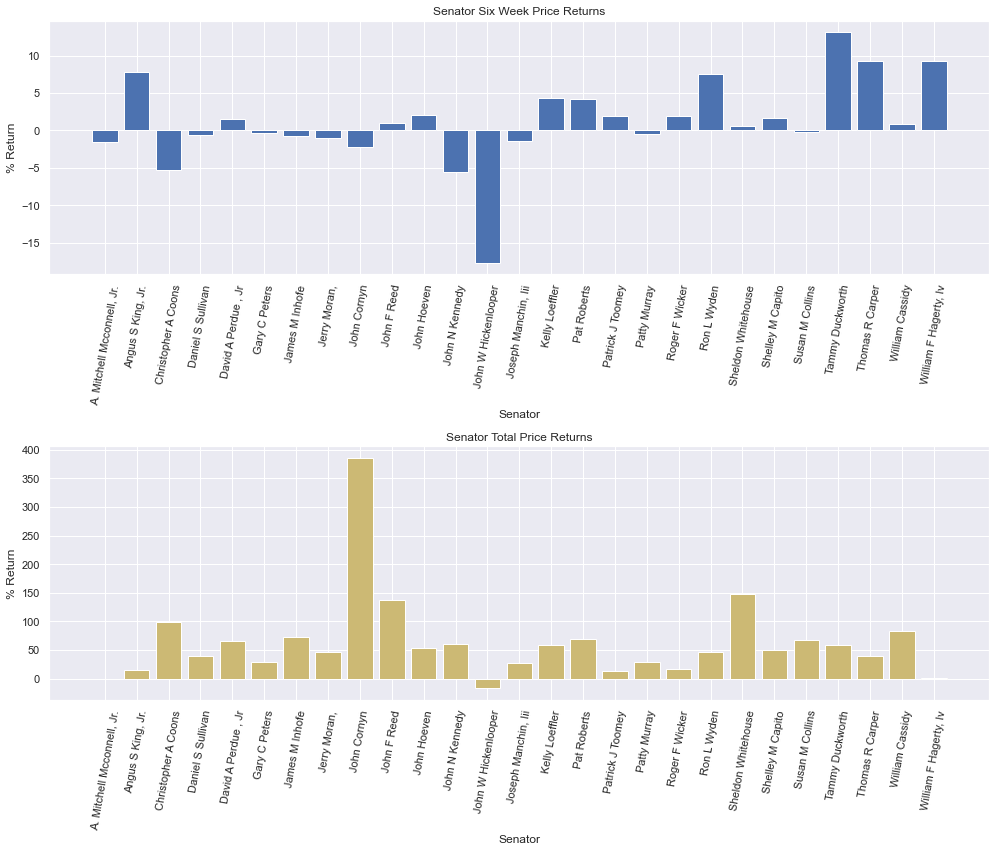

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Plut subplots and create bar charts
for idx in range(2):
    
    plt.subplot(2, 1, idx + 1)
    
    if idx == 0:
        plt.bar(sixwk["senator"], sixwk["6w_pct_change"], color="b")
        plt.title("Senator Six Week Price Returns")
    else:
        plt.bar(total["senator"], total["total_pct_change"], color="y")
        plt.title("Senator Total Price Returns")
    
    # Resize and label
    plt.gcf().set_size_inches((14, 12))
    plt.ylabel("% Return")
    plt.xlabel("Senator")
    plt.xticks(rotation = 80)
    
plt.tight_layout()

plt.show()


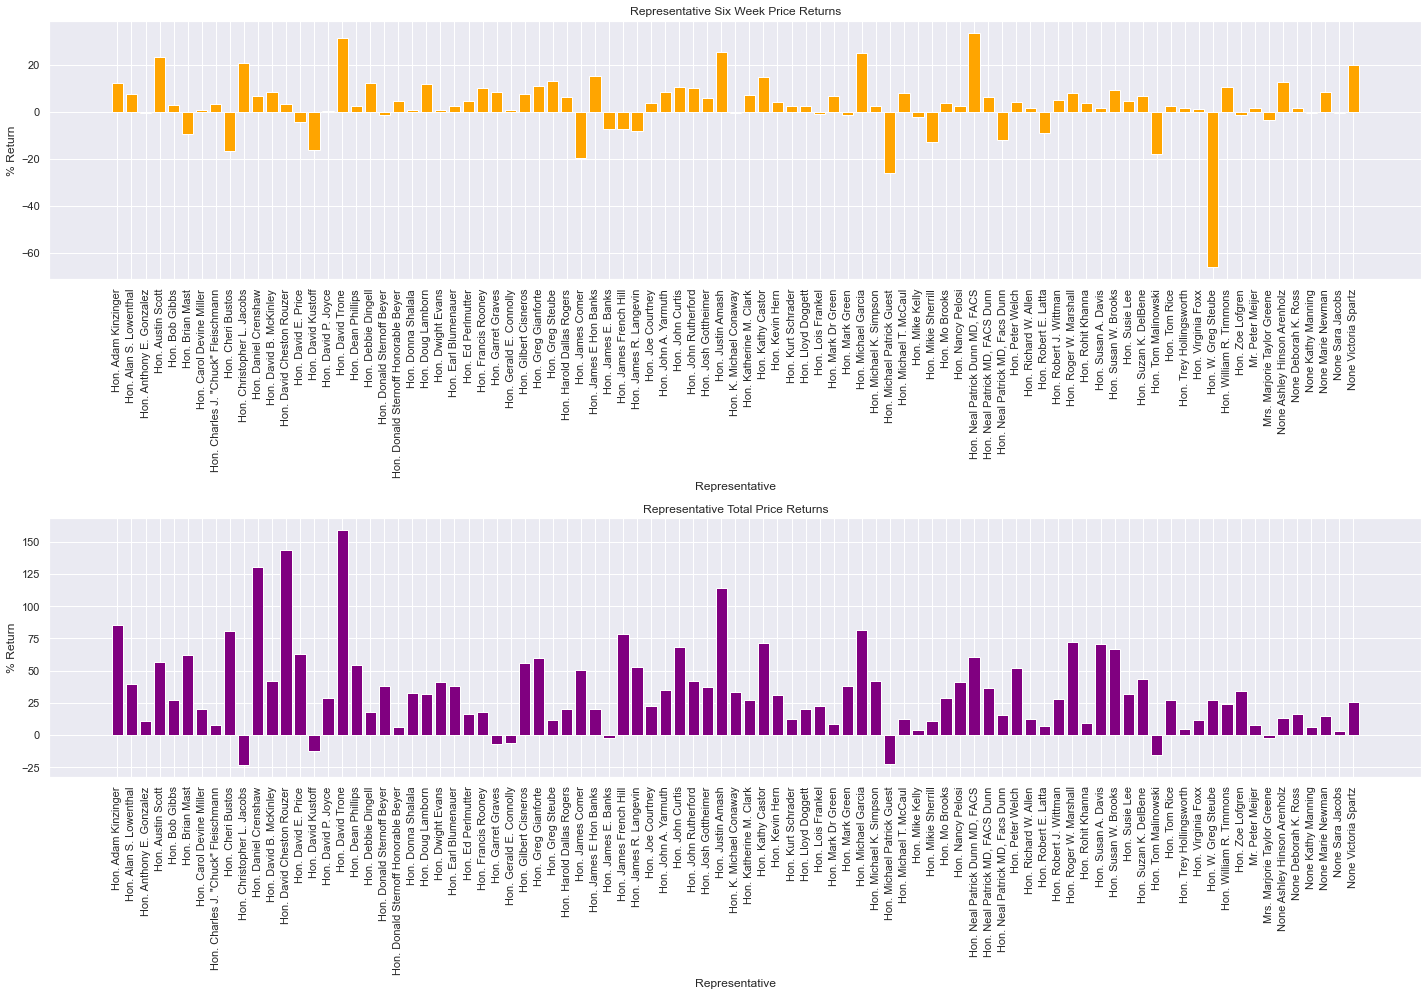

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# plot subplots of barcharts
for idx in range(2):
    
    plt.subplot(2, 1, idx + 1)

    if idx == 0:
        plt.bar(sixwk_house["representative"], sixwk_house["6w_pct_change"], color="orange")
        plt.title("Representative Six Week Price Returns")
    else:
        plt.bar(total_house["representative"], total_house["total_pct_change"], color="purple")
        plt.title("Representative Total Price Returns")
    
    # Resize and label
    plt.gcf().set_size_inches((20, 14))
    plt.ylabel("% Return")
    plt.xlabel("Representative")
    plt.xticks(rotation = 90)
    
plt.tight_layout()

plt.show()


The above two sets of graps show the average return per senator (above) and per representative (bellow) for 6 weeks after their purchase and from purchase to current. By looking at these graphs we can see that  a significant percent of the time all congressmen make considerable returns on their investments in the long term. However, its important to note that the 6 week returns are not extremely high and even show some loss, so this supports the theory that congressmen have good ability to trade in the long term. It also goes against the idea of insider information amongst these powerful people as they dont seem to make very large returns very quickly.

In [51]:
# Making smaller sample sizes for next plot, much easier to read
sen_sample = senate_data_final.tail(125).reset_index()
house_sample = house_data_final.head(125).reset_index()

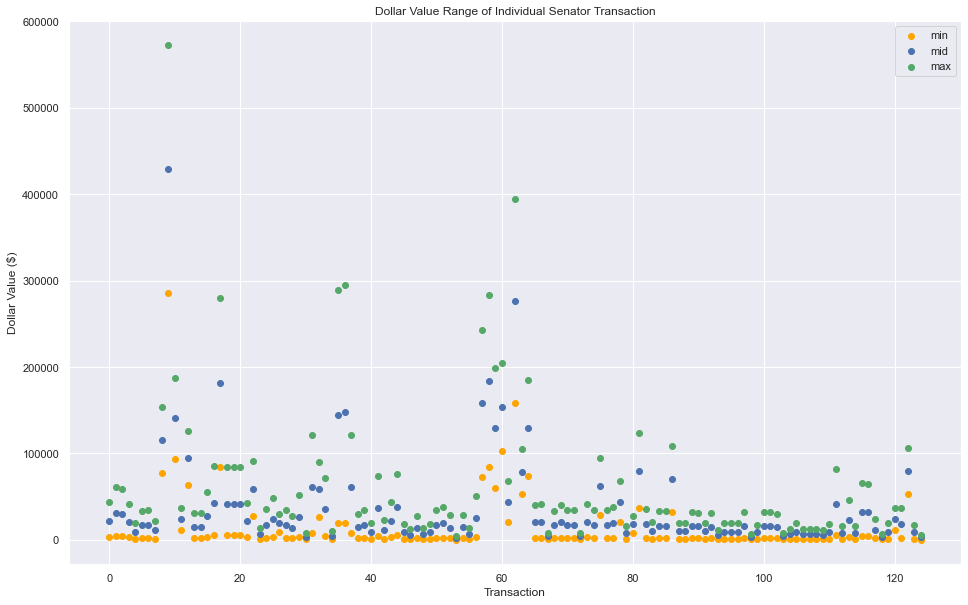

In [52]:
# plotting the min, mid, and max of current value in dollars
plt.scatter(sen_sample.index, sen_sample["min current ($)"], color="orange")
plt.scatter(sen_sample.index, sen_sample["mid current ($)"], color="b")
plt.scatter(sen_sample.index, sen_sample["max current ($)"], color="g")

# Sizing and labeling
plt.gcf().set_size_inches((16, 10))
plt.ylabel("Dollar Value ($)")
plt.xlabel("Transaction")
plt.title("Dollar Value Range of Individual Senator Transaction")
plt.legend(["min", "mid", "max"])


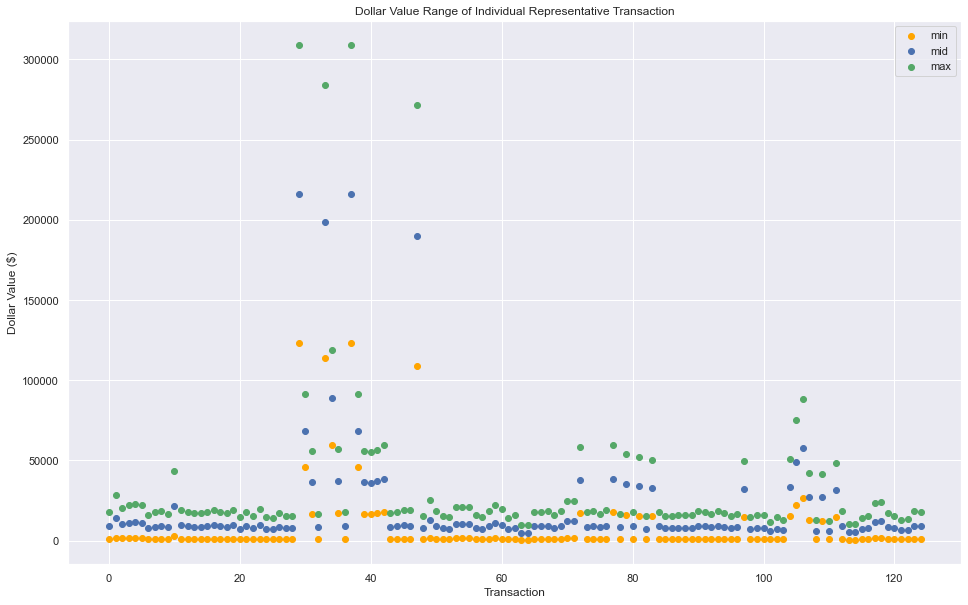

In [53]:
# plotting the min, mid, and max of current value in dollars
plt.scatter(house_sample.index, house_sample["min current ($)"], color="orange")
plt.scatter(house_sample.index, house_sample["mid current ($)"], color="b")
plt.scatter(house_sample.index, house_sample["max current ($)"], color="g")

# sizing and labeling
plt.gcf().set_size_inches((16, 10))
plt.ylabel("Dollar Value ($)")
plt.xlabel("Transaction")
plt.title("Dollar Value Range of Individual Representative Transaction")
plt.legend(["min", "mid", "max"])


The above two graphs show the range of current min, mid, and max value for a small population of senator and representative data. What these graphs show are the absolute absurdity that is the reporting system congressmen are allowed to use. For example, in the graph directly above it can be seen that there are a few transactions with a min just above $100,000, a mid around $200,000, and a max roughly around $300,000. This is a crazy range as the congressmen could have as much as three times more holdings in that stock. It reafirms the shadiness of their reporting style.

### Machine Learning

In [54]:
# Converts transaction dates to unix time so we can do ML
house_data_final = house_data_final.reset_index()
senate_data_final = senate_data_final.reset_index()

house_data_final['transaction_date'] =  pd.to_datetime(house_data_final['transaction_date'], format='%Y-%m-%d')
house_data_final['transaction_date'] = house_data_final['transaction_date'].apply(lambda x: x.value)

senate_data_final['transaction_date'] =  pd.to_datetime(senate_data_final['transaction_date'], format='%Y-%m-%d')
senate_data_final['transaction_date'] = senate_data_final['transaction_date'].apply(lambda x: x.value)

In [55]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.linear_model import LinearRegression

In [56]:
def regress_house(house_data_final, x_feat_list, y_feat='total_pct_change'):
    ''' Linear regression for the house data
    
    Args: 
        house_data_final(dataframe): dataframe of all the house data
        x_feat_list (list): the x features we are looking at
        y_feat (array): the data of the total percent change column

    '''
    # initialize regression object
    reg = LinearRegression()
    
    house_data_final2 = house_data_final.apply(pd.to_numeric)
    # get target variable
    x = house_data_final.loc[:, x_feat_list].values
    y = house_data_final.loc[:, y_feat].values
    
    
    
    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)    
    
    # print model   
    model_str = y_feat + f' = {reg.intercept_:.2f}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.2f} {feat}'
    print(model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')

In [57]:
def regress_senate(senate_data_final, x_feat_list, y_feat='total_pct_change'):
    ''' Linear regression for the senate data
    
    Args: 
        senate_data_final(dataframe): dataframe of all the senate data
        x_feat_list (list): the x features we are looking at
        y_feat (array): the data of the total percent change column

    '''
    # initialize regression object
    reg = LinearRegression()

    senate_data_final = senate_data_final.apply(pd.to_numeric)
    # get target variable
    x = senate_data_final.loc[:, x_feat_list].values
    y = senate_data_final.loc[:, y_feat].values
    
    

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)    
    
    # print model   
    model_str = y_feat + f' = {reg.intercept_:.2f}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.2f} {feat}'
    print(model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')

In [58]:
filtered_columns = ['transaction_date', 'transac_price', 'current_price', 'total_pct_change']

house_filtered = house_data_final.reindex(columns = filtered_columns)
house_filtered = house_filtered.reset_index()

regress_house(house_filtered, x_feat_list = ['transaction_date', 'transac_price', 'current_price'])

total_pct_change = 1366.79 + -0.00 transaction_date + -0.19 transac_price + 0.14 current_price
r2 = 0.13


In [59]:
filtered_columns = ['transaction_date', 'transac_price', 'current_price', 'total_pct_change']

senate_filtered = senate_data_final.reindex(columns = filtered_columns)
senate_filtered = senate_filtered.reset_index()

regress_senate(senate_filtered, x_feat_list = ['transaction_date', 'transac_price', 'current_price'])

total_pct_change = 912.23 + -0.00 transaction_date + -0.52 transac_price + 0.34 current_price
r2 = 0.244


### House

total_pct_change = 1366.48 + -0.00 transaction_date
r2 = 0.0546


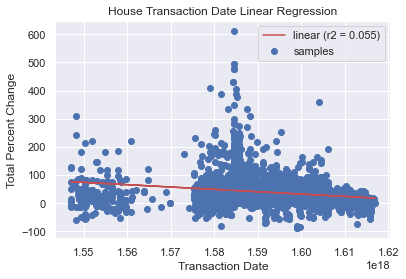

In [60]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['transaction_date']

# extract data
x = house_data_final.loc[:, x_feat_list].values
y = house_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('House Transaction Date Linear Regression')
# labels x axis
plt.xlabel('Transaction Date')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

total_pct_change = 38.94 + -0.01 transac_price
r2 = 0.00128


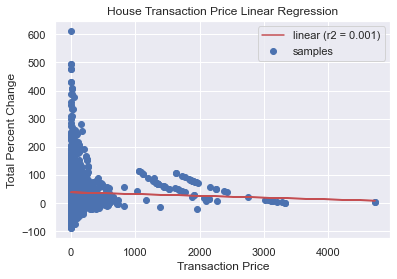

In [61]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['transac_price']

# extract data
x = house_data_final.loc[:, x_feat_list].values
y = house_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('House Transaction Price Linear Regression')
# labels x axis
plt.xlabel('Transaction Price')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

total_pct_change = 37.05 + 0.01 current_price
r2 = 0.00234


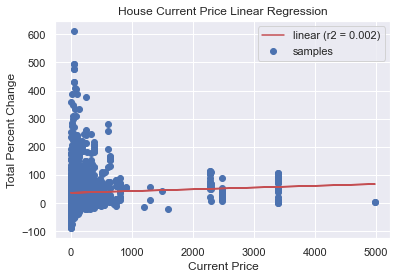

In [62]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['current_price']

# extract data
x = house_data_final.loc[:, x_feat_list].values
y = house_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('House Current Price Linear Regression')
# labels x axis
plt.xlabel('Current Price')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

### Senate

total_pct_change = 916.71 + -0.00 transaction_date
r2 = 0.0478


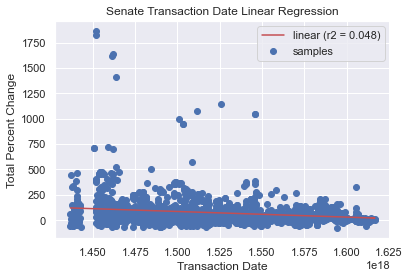

In [63]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['transaction_date']

# extract data
x = senate_data_final.loc[:, x_feat_list].values
y = senate_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('Senate Transaction Date Linear Regression')
# labels x axis
plt.xlabel('Transaction Date')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

total_pct_change = 67.89 + -0.00 transac_price
r2 = 7.25e-05


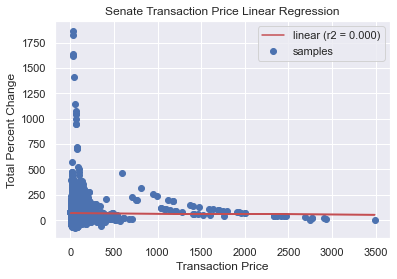

In [64]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['transac_price']

# extract data
x = senate_data_final.loc[:, x_feat_list].values
y = senate_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('Senate Transaction Price Linear Regression')
# labels x axis
plt.xlabel('Transaction Price')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

In [65]:
senate_data_final

,transaction_date,ticker,asset_description,senator,min ($),median ($),max ($),transac_price,transac_plus6wk_price,current_price,6w_pct_change,total_pct_change,min 6w ($),mid 6w ($),max 6w ($),min current ($),mid current ($),max current ($)
0,1614729600000000000,UBSI,"United Bankshares, Inc.",Shelley M Capito,100001,175000,250000,38.56,38.28,39.37,-0.73,2.10,99270.99,173722.50,248175.0,102101.02,178675.00,255250.0
1,1615248000000000000,USB,U.S. Bancorp,Shelley M Capito,1000,7500,15000,52.87,57.81,57.86,9.34,9.44,1093.40,8200.50,16401.0,1094.40,8208.00,16416.0
2,1615248000000000000,JPM,JPMorgan Chase &amp; Co.,Shelley M Capito,1000,7500,15000,151.50,153.42,153.30,1.27,1.19,1012.70,7595.25,15190.5,1011.90,7589.25,15178.5
3,1615248000000000000,BLK,"BlackRock, Inc.",Shelley M Capito,1000,7500,15000,707.98,811.06,811.45,14.56,14.61,1145.60,8592.00,17184.0,1146.10,8595.75,17191.5
4,1616544000000000000,WFC,Wells Fargo &amp; Company,Shelley M Capito,15001,32500,50000,38.36,43.61,43.84,13.69,14.29,17054.64,36949.25,56845.0,17144.64,37144.25,57145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,1437350400000000000,CLR,"Continental Resources, Inc. (NYSE)",James M Inhofe,15001,32500,50000,36.66,30.48,26.91,-16.86,-26.60,12471.83,27020.50,41570.0,11010.73,23855.00,36700.0
2488,1437436800000000000,ABT,Abbott Laboratories (NYSE),Shelley M Capito,1000,7500,15000,49.91,44.22,124.35,-11.40,149.15,886.00,6645.00,13290.0,2491.50,18686.25,37372.5
2489,1436918400000000000,FANG,"Diamondback Energy, Inc. (NASDAQ)",James M Inhofe,50001,75000,100000,72.71,62.48,77.54,-14.07,6.64,42965.86,64447.50,85930.0,53321.07,79980.00,106640.0
2490,1437955200000000000,DISCA,"Discovery Communications, Inc. (NASDAQ)","David A Perdue , Jr",1000,7500,15000,31.61,26.80,37.34,-15.22,18.13,847.80,6358.50,12717.0,1181.30,8859.75,17719.5


total_pct_change = 57.94 + 0.05 current_price
r2 = 0.0304


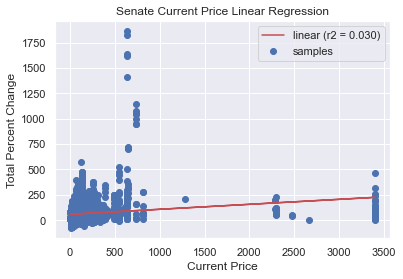

In [66]:
#set features
y_feat = 'total_pct_change'
x_feat_list=['current_price']

# extract data
x = senate_data_final.loc[:, x_feat_list].values
y = senate_data_final.loc[:, y_feat].values
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
# compute mean squared error
mse = ((y_pred - y) ** 2).mean()
r2 = r2_score(y_true=y, y_pred=y_pred)
# print   
model_str = y_feat + f' = {reg.intercept_:.2f}'
#iterate through
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef:.2f} {feat}'
print(model_str)
# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')


# scatter plot
plt.scatter(x[:,0], y, label='samples')

# Add plots for each model
plt.plot(x, y_pred, color='r', 
         label=f'linear (r2 = {r2:.3f})')


# gives graph a title
plt.title('Senate Current Price Linear Regression')
# labels x axis
plt.xlabel('Current Price')
# labels y axis
plt.ylabel('Total Percent Change')
# adds a legend
plt.legend()

### ML Results
Each of the linear regressions we created for both the house and senate using transaction price, transaction date, and current price indicated that those features are not good predictors of total percent change due to their low r^2 values. 

### The delay in stock reporting does not seem to have a major impact on the total returns of the purchase. Therefore, if one were to imitate the stock purchases of a senator/house member as soon as the information was made available to them they would likely experience a similar rate of return. 

## Discussion

We had some interesting results from our data analysis. Firstly, we discovered that members of the senate on average gain an annual return rate of almost 25%, while members of the house gain an annual return rate of approximately 45% - both return rates blow the average annual S&P500 return rate of 10% out of the water. We equate the S&P to the average retail investor since it is one of the most popular indicies. Secondly, through our machine learning analysis we came to the conclusion that the 6 weeks following the purchase date have little impact on the stock price at present day, meaning that congresspeople generally invest for the long term. 

These are significant results because our members of congress are trading substantially better than the average American. This information is made public - if you were to imitate these trades it's possible that you would see a similar return if you are prepared to hold long term. This could be surprising to people interested in stocks and also in politics. 

It's worth thinking about why these return rates are so high. Do they have access to information that we don't? Do they have financial advisors that are stock wizards? We think that this could be worth investigating, as members of congress have been known to cheat. We have little control over that though. What we do have control over is our own decisions, and with the access to this information, we could make the same trades as these people and have the same results. Like any financial trade, however, we would advise to strongly consider multiple streams of information rather than blind imitation, but seeing that your favorite senator made a big purchase can be a huge indicator that the stock will be appreciating in the coming month after. 